In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import skew

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, explained_variance_score, r2_score, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from category_encoders import TargetEncoder

# Set a different font that supports a wider range of characters
plt.rcParams['font.family'] = 'Liberation Sans'

In [ ]:
# Load the dataset
def load_data(filepath):
    df = pd.read_json(filepath)
    return df

In [ ]:
def preprocess_and_prepare_data(df, target_column):
    # Identify numerical, categorical, and boolean columns
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
    boolean_features = df.select_dtypes(include=["bool"]).columns.tolist()

    # Convert boolean features to integers (0 or 1)
    df[boolean_features] = df[boolean_features].astype(int)

    # Add boolean features to numerical feature list for processing
    numerical_features += boolean_features

    # Handle missing values (Imputation)
    num_imputer = SimpleImputer(strategy="median")
    df[numerical_features] = num_imputer.fit_transform(df[numerical_features])

    cat_imputer = SimpleImputer(strategy="most_frequent")
    df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])

    # Handle outliers (Winsorization) for target column (price)
    df['price'] = winsorize(df['price'], limits=(0, 0.10))  # Trim top 10%

    # Convert categorical columns to string if they aren't already
    df[categorical_features] = df[categorical_features].astype(str)

    # Split into X (features) and y (target variable)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    return X, y, categorical_features, numerical_features

In [ ]:
# Explore correlations
def explore_correlations(df):
    plt.figure(figsize=(12, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix after Transformation")
    plt.show()

In [ ]:
# Feature Engineering
def feature_engineering(df):
    # Example: Create interaction terms
    df['surface_bedrooms'] = df['surface'] * df['bedrooms']

    # Example: Create polynomial features
    df['surface_squared'] = df['surface'] ** 2

    df['bedrooms_squared'] = df['bedrooms'] ** 2

    # Create hierarchical feature
    df['hierarchical_loc'] = df['state'] + '_' + df['delegation'] + '_' + df['municipality']

    # Interaction between delegation and surface (encode delegation first)
    df['municipality_encoded'] = df['municipality'].astype('category').cat.codes
    df['municipality_surface_interaction'] = df['surface'] * df['municipality_encoded']


    # Feature for luxury count (number of luxury amenities)
    df['luxury_count'] = df[['elevator', 'equipped_kitchen', 'balcony', 'heating', 'air_conditioning', 'parking', 'garage']].sum(axis=1)


    # df['surface'] = pd.to_numeric(df['surface'], errors='coerce').fillna(0)
    # df['luxury_count'] = pd.to_numeric(df['luxury_count'], errors='coerce').fillna(0)
    # df['surface_luxury_interaction'] = df['surface'] * df['luxury_count']

    return df

In [ ]:
# Build preprocessing pipeline
def build_preprocessor(categorical_features, numerical_features):
    numerical_features = [f for f in numerical_features if f != 'price']

    preprocessor = ColumnTransformer([
        # Numerical features: standardize
        ('num', Pipeline([
            ('scaler', StandardScaler())  # Standardize numerical data
        ]), numerical_features),

        # Categorical features: one-hot encode
        ('cat', Pipeline([
            ('target_encoder', TargetEncoder(smoothing=5))  # Target encode categorical data
        ]), categorical_features)
    ])
    return preprocessor

In [ ]:
# Define models and parameter grids
def define_models():
    models = {
        "Linear Regression": LinearRegression(),
        "KNN": KNeighborsRegressor(),
        "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1, verbose=2),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    }

    param_grids = {
        "KNN": {"model__n_neighbors": [3, 5, 7, 9]},  # Test more values for n_neighbors
        "Random Forest": {
            "model__n_estimators": [130],  # Number of trees
            "model__max_depth": [None, 10, 20, 30],  # Maximum depth of trees
            "model__min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
            "model__max_features": ['sqrt', 'log2']  # Number of features to consider at each split
        },
        "Gradient Boosting": {"model__n_estimators": [50, 100, 200], "model__learning_rate": [0.01, 0.1, 0.2]},
    }

    return models, param_grids

In [ ]:
# Perform cross-validation and evaluate models
def evaluate_models(X, y, models, param_grids, preprocessor):
    print("🔍 Evaluating models...")
    kf = KFold(n_splits=7, shuffle=True, random_state=42)
    results = []

    best_pipeline = None  # Initialize the best pipeline tracker
    best_score = float('inf')

    for name, model in models.items():
        print(f"\n🔍 Training model: {name}")

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        if name in param_grids:
            print(f"🔍 Tuning hyperparameters for {name}")
            grid_search = GridSearchCV(
                pipeline, param_grids[name], cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            print(f"✅ Best parameters for {name}: {grid_search.best_params_}")
        else:
            best_model = pipeline

        print(f"   🛠️ Performing cross-validation for {name}...")
        scoring = {
            'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
            'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False),
            'R2': make_scorer(r2_score),
            'Explained Variance': make_scorer(explained_variance_score)
        }

        cv_results = cross_validate(best_model, X, y, cv=kf, scoring=scoring, return_train_score=False)

        mae = -cv_results['test_MAE'].mean()
        rmse = -cv_results['test_RMSE'].mean()
        r2 = cv_results['test_R2'].mean()
        evs = cv_results['test_Explained Variance'].mean()

        results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2, "Explained Variance": evs})

        if mae < best_score:
            best_score = mae
            best_pipeline = best_model

    print("✅ Model evaluation completed!")
    return pd.DataFrame(results).sort_values(by="RMSE"), best_pipeline

In [ ]:
# Visualize model performance
def visualize_performance(results_df):
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Model", y="RMSE", data=results_df, palette="viridis", hue="Model", dodge=False)
    plt.title("Model Comparison (RMSE)")
    plt.ylabel("RMSE")
    plt.legend([], [], frameon=False)
    plt.show()

In [ ]:
# Visualize predictions and errors
def visualize_predictions(X, y, best_model):
    y_pred = best_model.predict(X)

    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.6, color='blue', label="Predictions")
    plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label="Ideal Line")
    plt.title("Predictions vs Actual (Full Dataset)")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.legend()
    plt.show()

    errors = y_pred - y
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, color="red", bins=30)
    plt.title("Prediction Error Distribution")
    plt.xlabel("Error (Prediction - Actual)")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
def plot_price_boxplot(df, column='price'):
    plt.figure(figsize=(12, 5))
    sns.boxplot(x=df[column])
    plt.title(f"{column.capitalize()} Distribution After Winsorization")
    plt.show()


In [ ]:
def print_descriptive_statistics(df, column='price'):
    print(f"Descriptive Statistics for {column}:")
    print(df[column].describe())

In [ ]:
def calculate_iqr(df, column='price'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    print(f"IQR for {column}: {IQR:.2f}")

In [ ]:
def calculate_skewness(df, column='price'):
    skewness = skew(df[column])
    print(f"Skewness for {column}: {skewness:.2f}")

In [ ]:
def plot_price_histogram(df, column='price', winsorized_column='price_win'):
    plt.figure(figsize=(12, 5))

    # Original Distribution
    sns.histplot(df[column], bins=50, color='blue', alpha=0.5, label="Before Winsorization", kde=True)

    if winsorized_column:
        # Winsorized Distribution
        sns.histplot(df[winsorized_column], bins=50, color='red', alpha=0.5, label="After Winsorization", kde=True)

    plt.legend()
    plt.title(f"{column.capitalize()} Distribution Before vs. After Winsorization")
    plt.show()

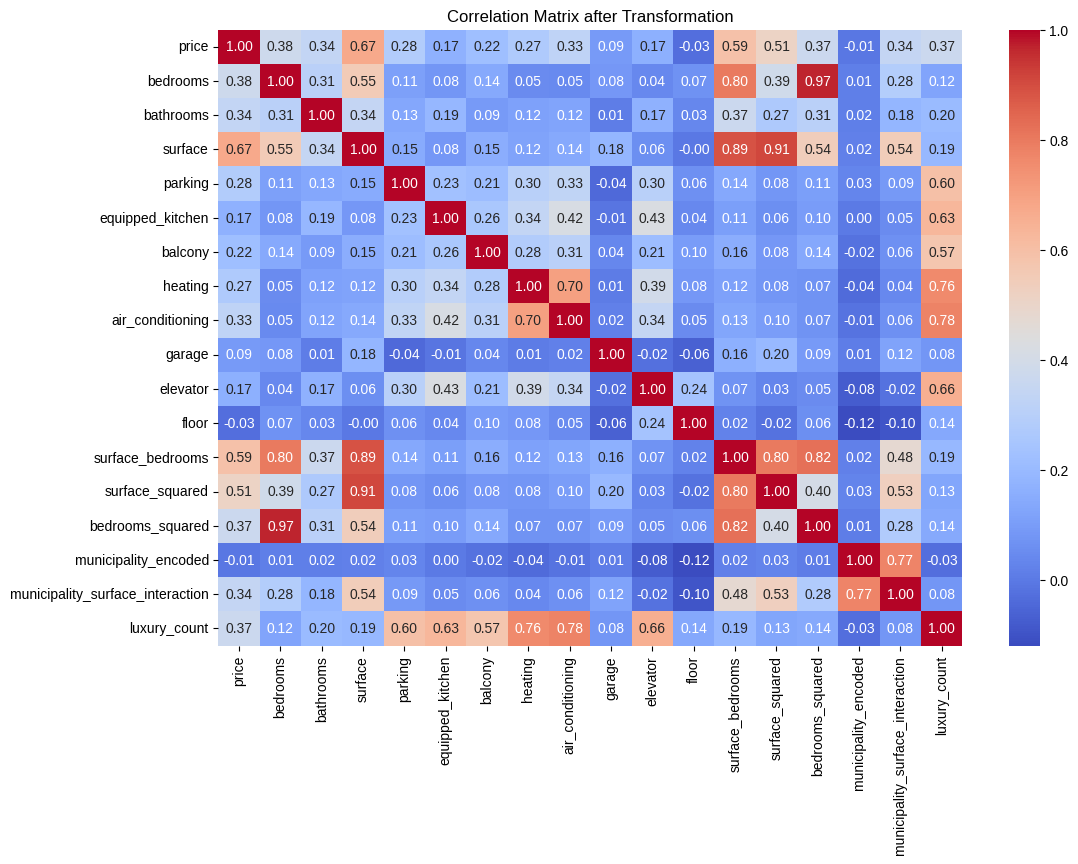

In [ ]:
# Load and preprocess data
df = load_data('/content/CleanedProcessed2.json')

df = feature_engineering(df)

X, y, categorical_features, numerical_features = preprocess_and_prepare_data(df, target_column='price')

explore_correlations(df)

# New Section

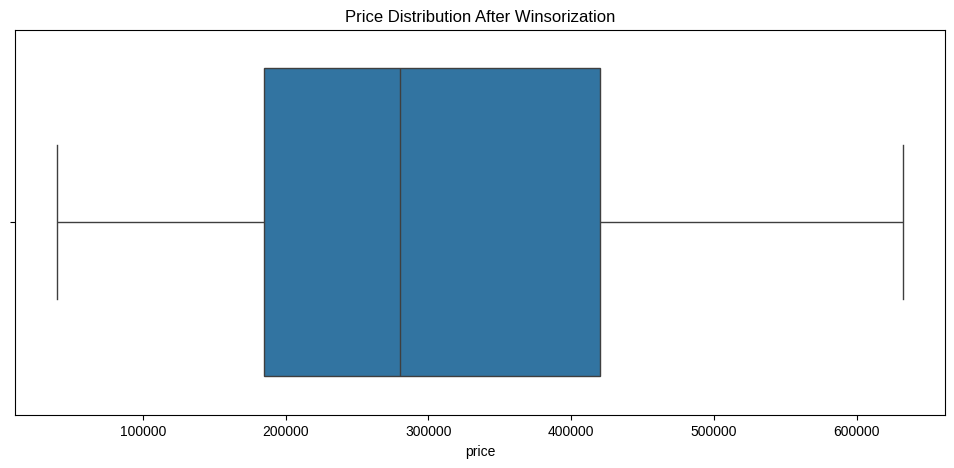

Descriptive Statistics for price:
count      8893.000000
mean     317212.282694
std      162604.455121
min       40000.000000
25%      185000.000000
50%      280000.000000
75%      420000.000000
max      632000.000000
Name: price, dtype: float64
IQR for price: 235000.00
Skewness for price: 0.62


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [ ]:
# Plot boxplot for price distribution
plot_price_boxplot(df)

# Print descriptive statistics for price
print_descriptive_statistics(df)

# Calculate IQR for price
calculate_iqr(df)

# Calculate skewness for price
calculate_skewness(df)

# Plot histogram for price distribution (with an optional 'price_winsorized' column if available)
# plot_price_histogram(df, column='price', winsorized_column='price_win')  # Only if you have a winsorized column

In [ ]:
# Prepare data
preprocessor = build_preprocessor(categorical_features, numerical_features)

# Define models and parameter grids
models, param_grids = define_models()

🔍 Evaluating models...

🔍 Training model: Linear Regression
   🛠️ Performing cross-validation for Linear Regression...

🔍 Training model: KNN
🔍 Tuning hyperparameters for KNN
Fitting 7 folds for each of 4 candidates, totalling 28 fits
✅ Best parameters for KNN: {'model__n_neighbors': 3}
   🛠️ Performing cross-validation for KNN...

🔍 Training model: Random Forest
🔍 Tuning hyperparameters for Random Forest
Fitting 7 folds for each of 24 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.7s


building tree 52 of 130
building tree 53 of 130
building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81 of 130
building tree 82 of 130
building tree 83 of 130
building tree 84 of 130
building tree 85 of 130
building tree 86 of 130
building tree 87 of 130
building tree 88 of 130
building tree 89 of 130
building tree 90 of 130
building tree 91 of 130
building tree 92 of 130
building tree 93

[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130building tree 18 of 130

building tree 19 of 130building tree 20 of 130

building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.5s


building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
building tree 43 of 130
building tree 44 of 130
building tree 45 of 130
building tree 46 of 130
building tree 47 of 130
building tree 48 of 130
building tree 49 of 130
building tree 50 of 130
building tree 51 of 130
building tree 52 of 130
building tree 53 of 130building tree 54 of 130

building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130building tree 75 of 130

building tree 76 of 130
building tree 77 of 130
building tree 78 of 130building tree 79 of 130

building tree 80

[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 130building tree 2 of 130

building tree 3 of 130
building tree 4 of 130
building tree 5 of 130building tree 6 of 130

building tree 7 of 130
building tree 8 of 130
building tree 9 of 130building tree 10 of 130

building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.5s


building tree 51 of 130building tree 52 of 130

building tree 53 of 130building tree 54 of 130

building tree 55 of 130building tree 56 of 130

building tree 57 of 130
building tree 58 of 130
building tree 59 of 130building tree 60 of 130

building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130building tree 68 of 130

building tree 69 of 130building tree 70 of 130

building tree 71 of 130
building tree 72 of 130
building tree 73 of 130building tree 74 of 130

building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81 of 130
building tree 82 of 130
building tree 83 of 130
building tree 84 of 130
building tree 85 of 130building tree 86 of 130

building tree 87 of 130
building tree 88 of 130
building tree 89 of 130building tree 90 of 130

building tree 91 of 130
building tree 92

[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 130building tree 2 of 130

building tree 3 of 130building tree 4 of 130

building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130building tree 20 of 130

building tree 21 of 130
building tree 22 of 130
building tree 23 of 130building tree 24 of 130

building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130building tree 30 of 130

building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130building tree 36 of 130

building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.5s


building tree 55 of 130building tree 56 of 130

building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130building tree 70 of 130

building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81 of 130
building tree 82 of 130
building tree 83 of 130
building tree 84 of 130
building tree 85 of 130
building tree 86 of 130
building tree 87 of 130
building tree 88 of 130
building tree 89 of 130
building tree 90 of 130
building tree 91 of 130
building tree 92 of 130
building tree 93 of 130
building tree 94 of 130
building tree 95 of 130
building tree 96

[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 130building tree 2 of 130

building tree 3 of 130building tree 4 of 130

building tree 5 of 130building tree 6 of 130

building tree 7 of 130
building tree 8 of 130
building tree 9 of 130building tree 10 of 130

building tree 11 of 130building tree 12 of 130

building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130building tree 31 of 130

building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130building tree 40 of 130

building tree 41 of 130building tree 42 of 130



[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.6s


building tree 43 of 130
building tree 44 of 130
building tree 45 of 130
building tree 46 of 130building tree 47 of 130

building tree 48 of 130building tree 49 of 130

building tree 50 of 130building tree 51 of 130

building tree 52 of 130building tree 53 of 130

building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130building tree 62 of 130

building tree 63 of 130building tree 64 of 130

building tree 65 of 130building tree 66 of 130

building tree 67 of 130building tree 68 of 130

building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81 of 130
building tree 82 of 130
building tree 83 of 130
building tree 84

[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130building tree 6 of 130

building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130building tree 15 of 130

building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.9s


building tree 47 of 130
building tree 48 of 130
building tree 49 of 130
building tree 50 of 130
building tree 51 of 130
building tree 52 of 130
building tree 53 of 130
building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81 of 130
building tree 82 of 130building tree 83 of 130

building tree 84 of 130building tree 85 of 130

building tree 86 of 130building tree 87 of 130

building tree 88

[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 130building tree 2 of 130

building tree 3 of 130building tree 4 of 130

building tree 5 of 130building tree 6 of 130

building tree 7 of 130
building tree 8 of 130
building tree 9 of 130building tree 10 of 130

building tree 11 of 130building tree 12 of 130

building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.5s


building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81 of 130
building tree 82 of 130building tree 83 of 130

building tree 84 of 130building tree 85 of 130

building tree 86 of 130
building tree 87 of 130
building tree 88 of 130
building tree 89 of 130
building tree 90 of 130
building tree 91 of 130
building tree 92 of 130
building tree 93 of 130
building tree 94 of 130
building tree 95

[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130building tree 18 of 130

building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130building tree 42 of 130

b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.5s


building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81 of 130
building tree 82 of 130
building tree 83 of 130
building tree 84 of 130
building tree 85 of 130
building tree 86 of 130
building tree 87 of 130
building tree 88 of 130
building tree 89 of 130
building tree 90 of 130building tree 91 of 130

building tree 92 of 130
building tree 93 of 130
building tree 94 of 130
building tree 95 of 130
building tree 96

[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.1s finished


✅ Best parameters for Gradient Boosting: {'model__learning_rate': 0.2, 'model__n_estimators': 200}
   🛠️ Performing cross-validation for Gradient Boosting...
✅ Model evaluation completed!

📊 Model Comparison:
                Model           MAE          RMSE        R²  Explained Variance
2      Random Forest  44306.736947  68572.515444  0.821727            0.821777
3  Gradient Boosting  53863.500595  75770.768029  0.782493            0.782575
0  Linear Regression  63331.819818  85190.990368  0.724896            0.724937
1                KNN  62083.232422  90818.816637  0.687374            0.687648


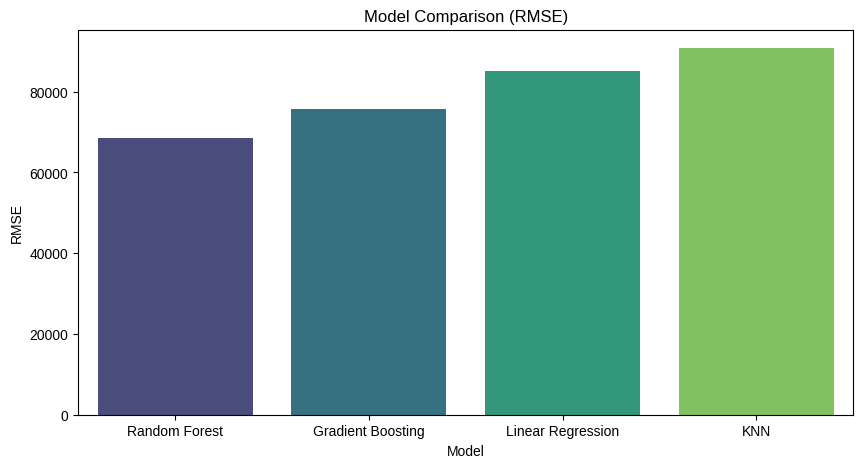

In [ ]:
# Evaluate models
results_df, best_pipeline = evaluate_models(X, y, models, param_grids, preprocessor)
print("\n📊 Model Comparison:\n", results_df)

# Visualize performance
visualize_performance(results_df)

Best Model Pipeline: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'surface', 'floor',
                                                   'surface_bedrooms',
                                                   'surface_squared',
                                                   'bedrooms_squared',
                                                   'municipality_encoded',
                                                   'municipality_surface_interaction',
                                                   'luxury_count', 'parking',
                                                   'equipped_kitchen',
                                                   'ba

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.2s finished


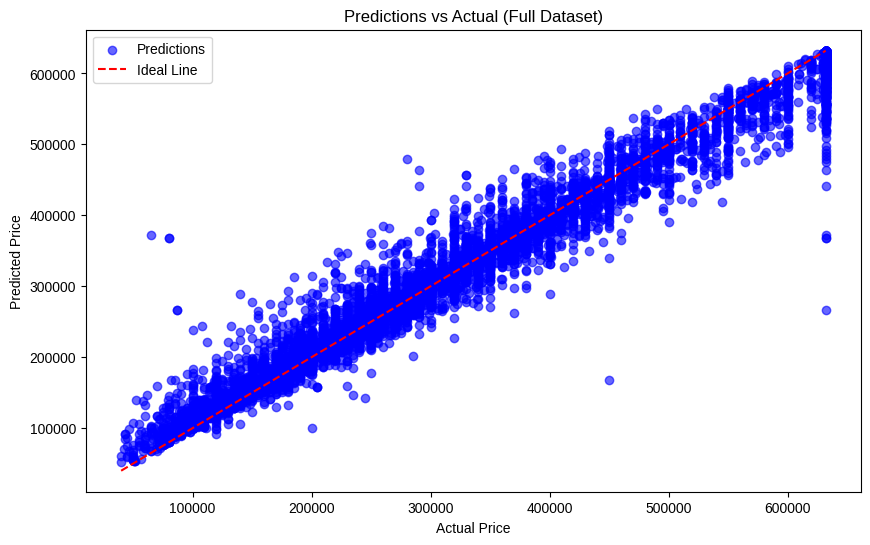

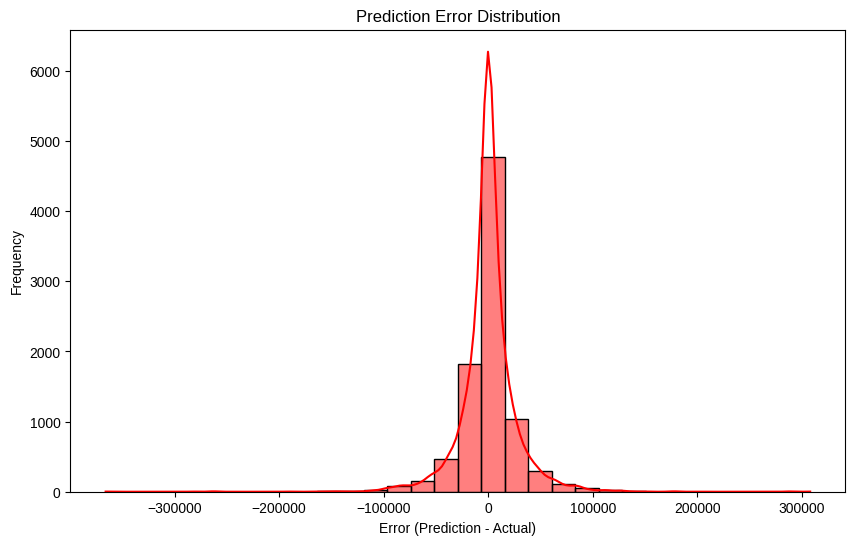

In [ ]:
# Visualize predictions and errors for the best model
best_model_name = results_df.iloc[0]["Model"]
# print(results_df.iloc[0]["Model"])
# best_model = models[best_model_name]
# print(best_model)
# best_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('model', best_model)
# ])

# print(best_pipeline)
# best_pipeline.fit(X, y)
# visualize_predictions(X, y, best_pipeline)

# Use the already selected best_pipeline from evaluate_models()
print(f"Best Model Pipeline: {best_pipeline}")

# No need to re-fit; best_pipeline is already tuned and fitted during evaluation
visualize_predictions(X, y, best_pipeline)


In [ ]:
import joblib

# Save the best model
joblib.dump(best_pipeline, 'best_apartment_price_model3.pkl')

['best_apartment_price_model3.pkl']

In [ ]:
import pandas as pd

# New input record
new_data = pd.DataFrame([{
    "state": "TUNIS",
    "parking": True,
    "bedrooms": 3,
    "bathrooms": 1,
    "surface": 135,
    "floor": 2,
    "air_conditioning": True,
    "balcony": True,
    "elevator": True,
    "equipped_kitchen": True,
    "heating": False,
    "garage": False,
    "municipality": "LES JARDINS",
    "delegation": "BAB BHAR"
}])


In [ ]:
# Apply transformations
new_data['surface_bedrooms'] = new_data['surface'] * new_data['bedrooms']

# Example: Create polynomial features
new_data['surface_squared'] = new_data['surface'] ** 2

new_data['bedrooms_squared'] = new_data['bedrooms'] ** 2

# Create hierarchical feature
new_data['hierarchical_loc'] = new_data['state'] + '_' + new_data['delegation'] + '_' + new_data['municipality']

# Interaction between delegation and surface (encode delegation first)
new_data['municipality_encoded'] = new_data['municipality'].astype('category').cat.codes
new_data['municipality_surface_interaction'] = new_data['surface'] * new_data['municipality_encoded']

# Feature for luxury count (number of luxury amenities)
new_data['luxury_count'] = new_data[
    ['elevator', 'equipped_kitchen', 'balcony', 'heating', 'air_conditioning', 'parking', 'garage']].sum(axis=1)


# Predict the price for the new record
predicted_price = best_pipeline.predict(new_data)[0]

print(f"Predicted Price: {predicted_price:.2f} TND")

Predicted Price: 397476.54 TND


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.0s finished
